In [1]:
# =========================
# BLOCK 1 — PREPROCESSING
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

# ---- File paths (must match your existing ones) ----
BASE = "/Users/adithyamadduri/Downloads/syn65414912"
ANML_PATH   = os.path.join(BASE, "OhNM2025_ROSMAP_plasma_Soma7k_protein_level_ANML_log10.csv")
SAMPLE_PATH = os.path.join(BASE, "OhNM2025_ROSMAP_plasma_Soma7k_sample_metadata.csv")

# ---- Output folders for the two baselines ----
out_dir_random = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_random"
out_dir_demo   = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_demo_only"
os.makedirs(out_dir_random, exist_ok=True)
os.makedirs(out_dir_demo, exist_ok=True)

# ---- Load ----
df_levels = pd.read_csv(ANML_PATH)  # rows: projid_visit, cols: proteins
df_meta   = pd.read_csv(SAMPLE_PATH)

# ---- Sanity: keys present? ----
assert "projid_visit" in df_levels.columns, "projid_visit missing in protein matrix."
for col in ["projid_visit","projid","msex","age_at_visit","educ","apoe_genotype","Diagnosis"]:
    assert col in df_meta.columns, f"{col} missing in sample metadata."

# ---- Align on visit ----
df = pd.merge(df_meta, df_levels, on="projid_visit", how="inner", validate="one_to_one")
print("Aligned shape:", df.shape)

# ---- Labels (four groups) ----
df["Diagnosis"] = df["Diagnosis"].astype(str).str.strip()
valid_classes = {"MCI","NCI","AD","AD+"}
df = df[df["Diagnosis"].isin(valid_classes)].reset_index(drop=True)
print("Class counts:\n", df["Diagnosis"].value_counts())

# ---- Grouping key ----
df["projid"] = df["projid"].astype(str)

# ---- Sex to int and build strata label (Diagnosis × sex) ----
df["msex"] = df["msex"].astype(int)
df["strata"] = df["Diagnosis"] + "_" + df["msex"].astype(str)

# ---- APOE one-hot (Unknown for NaN) ----
def format_apoe(x):
    if pd.isna(x):
        return "Unknown"
    try:
        return str(int(float(x)))  # e.g., 33.0 -> "33"
    except Exception:
        s = str(x).strip()
        return s if s else "Unknown"

df["apoe_str"] = df["apoe_genotype"].apply(format_apoe)

try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

apoe_ohe = ohe.fit_transform(df[["apoe_str"]])
apoe_cols = [c.replace("apoe_str_","APOE_") for c in ohe.get_feature_names_out()]
df_apoe  = pd.DataFrame(apoe_ohe, columns=apoe_cols, index=df.index)

# ---- Numeric covariates (unscaled) ----
for col in ["age_at_visit","educ"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ---- Build DEMOGRAPHICS-ONLY matrix: age, educ, msex, APOE dummies ----
X_demo = pd.concat([df[["age_at_visit","educ","msex"]], df_apoe], axis=1)
y       = df["Diagnosis"].astype(str).values
groups  = df["projid"].values
strata  = df["strata"].values

# ---- Classes/utility (match your main script) ----
classes = ["MCI","NCI","AD","AD+"]
def safe_cls(c): return c.replace("+","plus").replace(" ","_").replace("/","-")
seeds = [1,2,3,4,5]

print("X_demo shape:", X_demo.shape)
print("APOE levels seen:", sorted(set(df['apoe_str'])))

# ---- Helper: group-aware stratified 70/30 split (exactly as in your code) ----
def group_stratified_shuffle_split(df_index, strata_all, groups_all, test_size=0.30, random_state=0):
    """Return train_idx, test_idx ensuring groups stay intact and class-sex balance is approx preserved.
       Strategy: assign each group a single stratum = mode(strata) among its rows, then stratified split at group level.
    """
    rng = np.random.RandomState(random_state)
    data = pd.DataFrame({"idx": df_index, "strata": strata_all, "group": groups_all})

    grp_mode = (
        data.groupby("group")["strata"]
        .agg(lambda s: s.value_counts().idxmax())
    )
    grp_mode = grp_mode.sample(frac=1.0, random_state=random_state)  # shuffle groups

    train_groups, test_groups = [], []
    for s_val, grp_ids in grp_mode.groupby(grp_mode.values):
        g_list = list(grp_ids.index)
        rng.shuffle(g_list)
        n_test = max(1, int(round(test_size * len(g_list))))
        test_groups.extend(g_list[:n_test])
        train_groups.extend(g_list[n_test:])

    train_mask = np.isin(groups_all, train_groups)
    test_mask  = np.isin(groups_all,  test_groups)
    return np.where(train_mask)[0], np.where(test_mask)[0]

Aligned shape: (973, 7301)
Class counts:
 Diagnosis
NCI    507
MCI    262
AD     167
AD+     17
Name: count, dtype: int64
X_demo shape: (953, 10)
APOE levels seen: ['22', '23', '24', '33', '34', '44', 'Unknown']



[Seed 1] Train n=670 | Test n=283 | Groups train=610 test=261
  [StratifiedRandom :: MCI] AUC=0.489
  [StratifiedRandom :: NCI] AUC=0.484
  [StratifiedRandom :: AD] AUC=0.508
  [StratifiedRandom :: AD+] AUC=0.688

[Seed 2] Train n=674 | Test n=279 | Groups train=610 test=261
  [StratifiedRandom :: MCI] AUC=0.512
  [StratifiedRandom :: NCI] AUC=0.525
  [StratifiedRandom :: AD] AUC=0.533
  [StratifiedRandom :: AD+] AUC=0.611

[Seed 3] Train n=674 | Test n=279 | Groups train=610 test=261
  [StratifiedRandom :: MCI] AUC=0.517
  [StratifiedRandom :: NCI] AUC=0.503
  [StratifiedRandom :: AD] AUC=0.472
  [StratifiedRandom :: AD+] AUC=0.526

[Seed 4] Train n=665 | Test n=288 | Groups train=610 test=261
  [StratifiedRandom :: MCI] AUC=0.543
  [StratifiedRandom :: NCI] AUC=0.516
  [StratifiedRandom :: AD] AUC=0.441
  [StratifiedRandom :: AD+] AUC=0.504

[Seed 5] Train n=671 | Test n=282 | Groups train=610 test=261
  [StratifiedRandom :: MCI] AUC=0.535
  [StratifiedRandom :: NCI] AUC=0.417
  [St

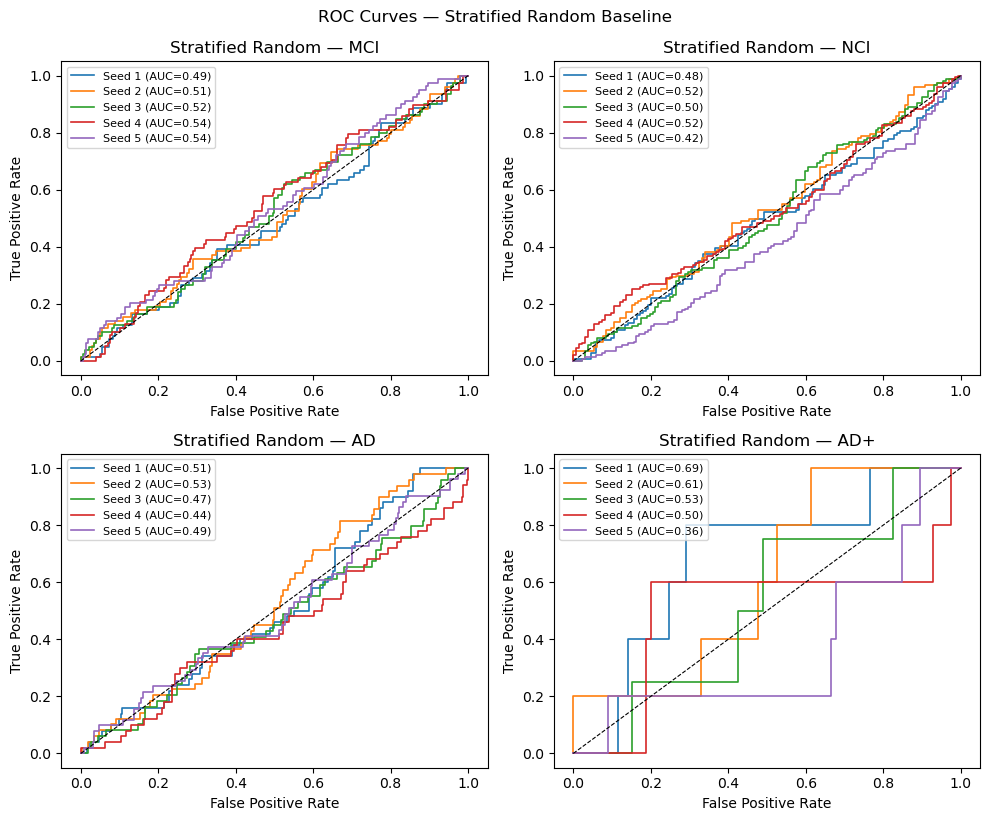

In [3]:
# ============================================================
# BLOCK 2 — BASELINE A: Stratified Random (prior-centered)
# ============================================================
from sklearn.metrics import roc_auc_score

all_rows = []  # to collect AUCs per seed × class

for seed in seeds:
    tr_idx, te_idx = group_stratified_shuffle_split(
        df_index=np.arange(len(X_demo)),
        strata_all=strata,
        groups_all=groups,
        test_size=0.30,
        random_state=seed,
    )

    y_train_full = y[tr_idx]
    y_test_full  = y[te_idx]

    print(f"\n[Seed {seed}] Train n={len(tr_idx)} | Test n={len(te_idx)} | "
          f"Groups train={len(np.unique(groups[tr_idx]))} test={len(np.unique(groups[te_idx]))}")

    for cls in classes:
        # one-vs-rest label
        y_train = (y_train_full == cls).astype(int)
        y_test  = (y_test_full  == cls).astype(int)

        # Estimate train prior for the positive class
        p = y_train.mean() if len(y_train) > 0 else 0.0

        # Generate random probabilities centered on prior p
        # Use a Beta distribution with mean ~p and moderate concentration to avoid degenerate AUCs
        # alpha = p * c, beta = (1-p) * c
        c = 50.0
        alpha = max(1e-3, p * c)
        beta  = max(1e-3, (1.0 - p) * c)
        rng = np.random.RandomState(seed * 9973 + hash(cls) % 100003)
        y_score = rng.beta(alpha, beta, size=len(y_test))

        # Compute AUC (only if both classes present in test)
        auc = (roc_auc_score(y_test, y_score)
               if (y_test.sum() > 0 and y_test.sum() < len(y_test)) else float("nan"))
        print(f"  [StratifiedRandom :: {cls}] AUC={auc:.3f}")

        # Save per-class CSV (to mirror your downstream averaging/plotting)
        out_csv = os.path.join(out_dir_random, f"seed{seed}_{safe_cls(cls)}.csv")
        pd.DataFrame({"y_true": y_test.astype(int),
                      "y_score": y_score.astype(float)}).to_csv(out_csv, index=False)

        all_rows.append({"seed": seed, "class": cls, "auc": auc})

# ---- Aggregate + plot
df_rand_auc = pd.DataFrame(all_rows)
df_rand_auc.to_csv(os.path.join(out_dir_random, "summary_auc.csv"), index=False)

# ---- Plot ROC curves for each class and seed ----
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
for cls in classes:
    plt.subplot(2, 2, classes.index(cls) + 1)
    for seed in seeds:
        df_pred = pd.read_csv(os.path.join(out_dir_random, f"seed{seed}_{safe_cls(cls)}.csv"))
        if len(np.unique(df_pred["y_true"])) < 2:
            continue
        fpr, tpr, _ = roc_curve(df_pred["y_true"], df_pred["y_score"])
        auc_val = roc_auc_score(df_pred["y_true"], df_pred["y_score"])
        plt.plot(fpr, tpr, lw=1.2, label=f"Seed {seed} (AUC={auc_val:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=0.8)
    plt.title(f"Stratified Random — {cls}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize=8)
    plt.tight_layout()

plt.suptitle("ROC Curves — Stratified Random Baseline", y=1.02)
plt.show()

In [7]:
# ============================================================
# BLOCK 2B — Compute full metric summary (for reproducible table)
# ============================================================
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

metric_rows = []

for seed in seeds:
    for cls in classes:
        df_pred_path = os.path.join(out_dir_random, f"seed{seed}_{safe_cls(cls)}.csv")
        if not os.path.exists(df_pred_path):
            continue
        df_pred = pd.read_csv(df_pred_path)

        y_true = df_pred["y_true"].values
        y_score = df_pred["y_score"].values

        # Skip degenerate cases (all 0 or all 1)
        if len(np.unique(y_true)) < 2:
            continue

        # Convert probabilities to binary predictions (0.5 threshold)
        y_pred = (y_score >= 0.5).astype(int)

        # Compute metrics
        auc  = roc_auc_score(y_true, y_score)
        acc  = accuracy_score(y_true, y_pred)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)

        metric_rows.append({
            "seed": seed,
            "class": cls,
            "AUC": auc,
            "Accuracy": acc,
            "F1": f1,
            "Precision": prec,
            "Recall": rec
        })

# ---- Aggregate (mean ± std) per class ----
df_metrics = pd.DataFrame(metric_rows)
summary = (
    df_metrics.groupby("class")[["AUC","Accuracy","F1","Precision","Recall"]]
    .agg(["mean","std"])
    .round(3)
)

# ---- Save summary table reproducibly ----
summary_csv_path = os.path.join(out_dir_random, "/Users/adithyamadduri/Desktop/Projects/ml4h_project/Final_figures/Baselines/summary_metrics_random_baseline.csv")

summary.to_csv(summary_csv_path)



[Seed 1] Train n=670 | Test n=283 | Groups train=610 test=261
[flaml.automl.logger: 10-14 14:52:15] {1752} INFO - task = classification
[flaml.automl.logger: 10-14 14:52:15] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 10-14 14:52:15] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 10-14 14:52:15] {1979} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 10-14 14:52:15] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-14 14:52:15] {2417} INFO - Estimated sufficient time budget=179s. Estimated necessary time budget=0s.
[flaml.automl.logger: 10-14 14:52:15] {2466} INFO -  at 0.0s,	estimator lgbm's best error=0.4590,	best estimator lgbm's best error=0.4590
[flaml.automl.logger: 10-14 14:52:15] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-14 14:52:15] {2466} INFO -  at 0.0s,	estimator lgbm's best error=0.4572,	best estimator lgbm's best error=0.4572
[flaml.automl.logger: 10-14 14:

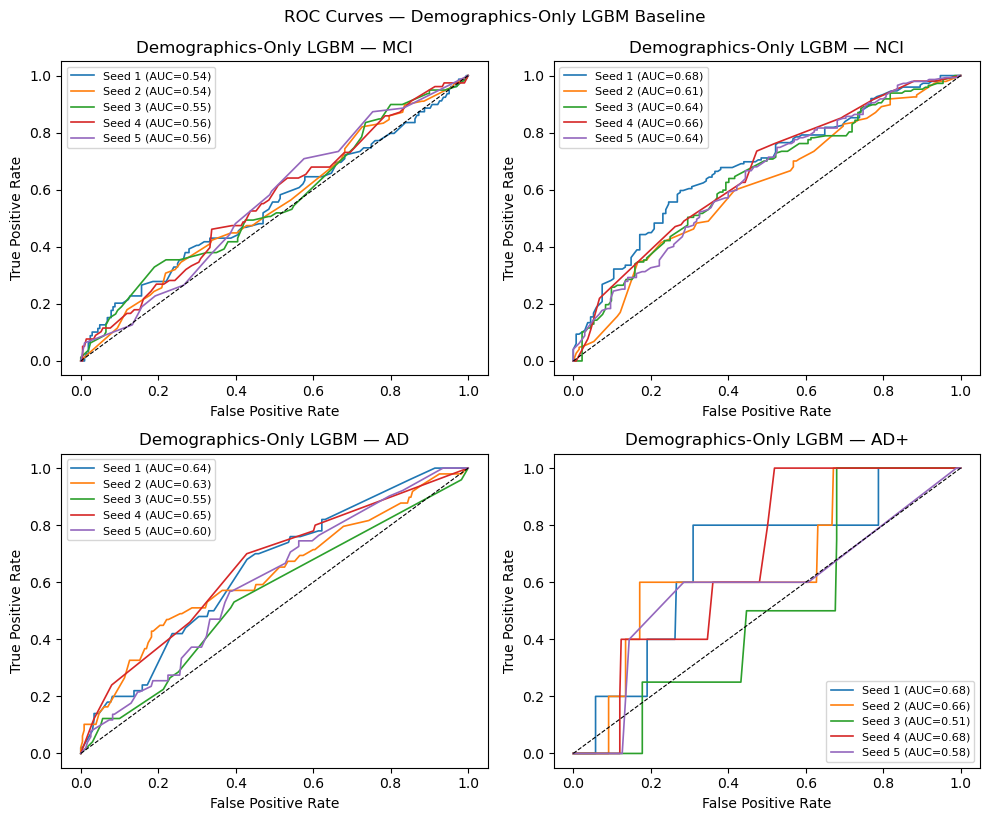

In [9]:
# ============================================================
# BLOCK 3 — BASELINE B: Demographics-Only LightGBM (AutoML)
# ============================================================
from flaml import AutoML
from sklearn.metrics import roc_auc_score

all_rows = []

for seed in seeds:
    tr_idx, te_idx = group_stratified_shuffle_split(
        df_index=np.arange(len(X_demo)),
        strata_all=strata,
        groups_all=groups,
        test_size=0.30,
        random_state=seed,
    )

    X_train = X_demo.iloc[tr_idx].copy()
    X_test  = X_demo.iloc[te_idx].copy()
    y_train_full = y[tr_idx]
    y_test_full  = y[te_idx]

    print(f"\n[Seed {seed}] Train n={len(tr_idx)} | Test n={len(te_idx)} | "
          f"Groups train={len(np.unique(groups[tr_idx]))} test={len(np.unique(groups[te_idx]))}")

    for cls in classes:
        y_train = (y_train_full == cls).astype(int)
        y_test  = (y_test_full  == cls).astype(int)

        automl = AutoML()
        settings = {
            "time_budget": 100,
            "metric": "roc_auc",
            "task": "classification",
            "eval_method": "cv",
            "estimator_list": ["lgbm"],  # force LightGBM
            "log_file_name": os.path.join(out_dir_demo, f"flaml_seed{seed}_{safe_cls(cls)}.log"),
            "seed": seed,
        }
        automl.fit(X_train=X_train, y_train=y_train, **settings)

        # Predict proba for positive class
        y_score = automl.predict_proba(X_test)[:, 1]
        auc = (roc_auc_score(y_test, y_score)
               if (y_test.sum() > 0 and y_test.sum() < len(y_test)) else float("nan"))
        print(f"  [Demo-Only LGBM :: {cls}] AUC={auc:.3f}")

        # Persist model + CSV
        automl.pickle(os.path.join(out_dir_demo, f"seed{seed}_{safe_cls(cls)}_automl.pkl"))
        out_csv = os.path.join(out_dir_demo, f"seed{seed}_{safe_cls(cls)}.csv")
        pd.DataFrame({"y_true": y_test.astype(int),
                      "y_score": y_score.astype(float)}).to_csv(out_csv, index=False)

        all_rows.append({"seed": seed, "class": cls, "auc": auc})

# ---- Aggregate + plot
df_demo_auc = pd.DataFrame(all_rows)
df_demo_auc.to_csv(os.path.join(out_dir_demo, "summary_auc.csv"), index=False)

# ---- Plot ROC curves for each class and seed ----
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))
for cls in classes:
    plt.subplot(2, 2, classes.index(cls) + 1)
    for seed in seeds:
        df_pred = pd.read_csv(os.path.join(out_dir_demo, f"seed{seed}_{safe_cls(cls)}.csv"))
        if len(np.unique(df_pred["y_true"])) < 2:
            continue
        fpr, tpr, _ = roc_curve(df_pred["y_true"], df_pred["y_score"])
        auc_val = roc_auc_score(df_pred["y_true"], df_pred["y_score"])
        plt.plot(fpr, tpr, lw=1.2, label=f"Seed {seed} (AUC={auc_val:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=0.8)
    plt.title(f"Demographics-Only LGBM — {cls}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize=8)
    plt.tight_layout()

plt.suptitle("ROC Curves — Demographics-Only LGBM Baseline", y=1.02)
plt.show()

In [11]:
# ============================================================
# BLOCK 3B — Compute full metric summary (for reproducible table)
# ============================================================
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

metric_rows = []

for seed in seeds:
    for cls in classes:
        # Pull from the demographics baseline folder, not random
        df_pred_path = os.path.join(out_dir_demo, f"seed{seed}_{safe_cls(cls)}.csv")
        if not os.path.exists(df_pred_path):
            continue
        df_pred = pd.read_csv(df_pred_path)

        y_true = df_pred["y_true"].values
        y_score = df_pred["y_score"].values

        # Skip degenerate cases (all 0 or all 1)
        if len(np.unique(y_true)) < 2:
            continue

        # Convert probabilities to binary predictions (0.5 threshold)
        y_pred = (y_score >= 0.5).astype(int)

        # Compute metrics
        auc  = roc_auc_score(y_true, y_score)
        acc  = accuracy_score(y_true, y_pred)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)

        metric_rows.append({
            "seed": seed,
            "class": cls,
            "AUC": auc,
            "Accuracy": acc,
            "F1": f1,
            "Precision": prec,
            "Recall": rec
        })

# ---- Aggregate (mean ± std) per class ----
df_metrics = pd.DataFrame(metric_rows)
summary = (
    df_metrics.groupby("class")[["AUC","Accuracy","F1","Precision","Recall"]]
    .agg(["mean","std"])
    .round(3)
)

# ---- Save summary table reproducibly ----
# Save both locally within baseline folder AND externally for figures
summary_csv_local = os.path.join(out_dir_demo, "summary_metrics_demographics_baseline.csv")
summary_csv_figs  = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/Final_figures/Baselines/summary_metrics_demographics_baseline.csv"

# ensure external directory exists
os.makedirs(os.path.dirname(summary_csv_figs), exist_ok=True)

summary.to_csv(summary_csv_local)
summary.to_csv(summary_csv_figs)

print(f"\n Saved metrics summary to:\n- {summary_csv_local}\n- {summary_csv_figs}")
print("\nPreview:")
display(summary)


✅ Saved metrics summary to:
- /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_demo_only/summary_metrics_demographics_baseline.csv
- /Users/adithyamadduri/Desktop/Projects/ml4h_project/Final_figures/Baselines/summary_metrics_demographics_baseline.csv

Preview:


AUC        Accuracy            F1        Precision        Recall  \
        mean    std     mean    std   mean    std      mean    std   mean   
class                                                                       
AD     0.614  0.041    0.824  0.003  0.008  0.018     0.200  0.447  0.004   
AD+    0.622  0.076    0.969  0.013  0.000  0.000     0.000  0.000  0.000   
MCI    0.551  0.007    0.720  0.007  0.044  0.086     0.287  0.441  0.028   
NCI    0.645  0.027    0.583  0.041  0.666  0.034     0.585  0.046  0.801   

              
         std  
class         
AD     0.009  
AD+    0.000  
MCI    0.055  
NCI    0.163